In [ ]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.4/840.4 kB 8.0 MB/s eta 0:00:00


In [ ]:
!pip install conllu

In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pickle
from torchmetrics import F1Score

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(0)

print("Using device:", device)

with open('en_atis-ud-dev.conllu', 'r') as f:
    dev_data = f.read()
with open('en_atis-ud-train.conllu', 'r') as f:
    train_data = f.read()
with open('en_atis-ud-test.conllu', 'r') as f:
    test_data = f.read()


def extract_sentences(data):
    """ Function to extract sentences from the dataset """
    return [line[9:] for line in data.split('\n') if line.startswith('# text = ')]

train_sentences = extract_sentences(train_data)
test_sentences = extract_sentences(test_data)
dev_sentences = extract_sentences(dev_data)


def extract_labels(data):
    output_data = []
    words = []
    labels = []

    lines = [line for line in data.split('\n') if not line.startswith(('# text = ', '# sent_id = ')) and line]

    for line in lines:
        elements = line.split('\t')
        temp = elements[0:2] + [elements[3]]

        if temp[0] != '1':
            words.append(temp[1])
            labels.append(temp[2])
        else:
            words = [temp[1]]
            labels = [temp[2]]
            output_data.append((words, labels))

    return output_data

training_data = extract_labels(train_data)
testing_data = extract_labels(test_data)
dev_data = extract_labels(dev_data)


word2idx = {}
tags2idx = {}
idx2tag = {}

for i, (sent, tags) in enumerate(training_data):
    for word in sent:
        if word in word2idx:
            continue
        else:
            word2idx[word] = len(word2idx)

    if i % 30 != 0:
        continue
    else:
        rand = np.random.randint(0, len(sent))
        sent[rand] = '<unk>'

    for tag in tags:
        if tag in tags2idx:
            continue
        else:
            tags2idx[tag] = len(tags2idx)
            idx2tag[len(tags2idx) - 1] = tag

if '<unk>' not in word2idx:
    word2idx['<unk>'] = len(word2idx)
if '<unk>' not in tags2idx:
    tags2idx['<unk>'] = len(tags2idx)
if '<unk>' not in idx2tag.values():
    idx2tag[len(tags2idx) - 1] = '<unk>'


with open('./Encoding_Dictionaries/word2idx.pkl', 'wb') as f:
    pickle.dump(word2idx, f)
with open('./Encoding_Dictionaries/idx2tag.pkl', 'wb') as f:
    pickle.dump(idx2tag, f)

EMBEDDING_DIM = 128
HIDDEN_DIM = 128
LEARNING_RATE = 0.1
NUM_EPOCHS = 10

print("Embedding size:", EMBEDDING_DIM)
print("Output size:", HIDDEN_DIM)
print("Learning rate:", LEARNING_RATE)
print("Epochs:", NUM_EPOCHS)


class LSTMTagger(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size):
        super(LSTMTagger, self).__init__()

        self.hidden_dim = hidden_dim
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim)
        self.hidden2tag = nn.Linear(hidden_dim, tagset_size)
        self.hidden = self.init_hidden()

    def init_hidden(self):
        return (
            torch.zeros(1, 1, self.hidden_dim),
            torch.zeros(1, 1, self.hidden_dim)
        )

    def forward(self, sentence):
        embeds = self.word_embeddings(sentence)
        embeds = embeds.view(len(sentence), 1, -1)
        lstm_out, self.hidden = self.lstm(embeds, self.hidden)
        lstm_out = lstm_out.view(-1, self.hidden_dim)
        tag_space = self.hidden2tag(lstm_out)
        tag_scores = F.log_softmax(tag_space, dim=1)
        return tag_scores

def prepare_sequence(seq, to_idx):
    idxs = []
    for w in seq:
        if w not in to_idx:
            idxs.append(to_idx['<unk>'])
        else:
            idxs.append(to_idx[w])
    return torch.tensor(idxs, dtype=torch.long).to(device)

model = LSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, len(word2idx), len(tags2idx)).to(device)
loss_function = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)

def train_model(model, data, num_epochs):
    for epoch in range(num_epochs):
        sentence_idx = 0
        while sentence_idx < len(data):
            sentence, tags = data[sentence_idx]
            model.zero_grad()
            model.hidden = model.init_hidden()
            sentence_in = prepare_sequence(sentence, word2idx)
            targets = prepare_sequence(tags, tags2idx)
            tag_scores = model(sentence_in)
            loss = loss_function(tag_scores, targets)
            loss.backward()
            optimizer.step()
            sentence_idx += 1

train_model(model, training_data, NUM_EPOCHS)

torch.save(model.state_dict(), "model_weights.pth")

def calculate_accuracy(model, data):
    model.eval()
    with torch.no_grad():
        correct = sum((torch.argmax(model(prepare_sequence(sentence, word2idx)), 1) == prepare_sequence(tags, tags2idx)).sum().item() for sentence, tags in data)
        total = sum(len(tags) for _, tags in data)
    return (correct / total) * 100

print("\nAccuracy on the training set:", calculate_accuracy(model, training_data))
print("Accuracy on the dev set:", calculate_accuracy(model, dev_data))
print("Accuracy on the test set:", calculate_accuracy(model, testing_data))

f1_score = F1Score(task="multiclass", num_classes=len(tags2idx))
f1_score.to(device)
actual = []
predicted = []

[(
    actual.extend(targets.tolist()),
    predicted.extend(predicted_tags.tolist())
) for sentence, tags in testing_data
  for (sentence_in, targets, tag_scores, predicted_tags) in [
        (prepare_sequence(sentence, word2idx),
         prepare_sequence(tags, tags2idx),
         model(prepare_sequence(sentence, word2idx)),
         torch.argmax(model(prepare_sequence(sentence, word2idx)), 1)
         )]
]

f1_score.update(torch.tensor(predicted), torch.tensor(actual))
f1_score.compute()
print("F1 score:", f1_score.compute().item() * 100)
print("\n")

sentence  = "When is the flight to denver"
sentence = sentence.lower().split()
sentence_copy = sentence.copy()
predicted = []

for i in model(prepare_sequence(sentence, word2idx)).argmax(1).tolist():
    predicted.append(idx2tag[i])

assert sentence == sentence_copy
print("Sentence:", sentence_copy)
print("Predicted:", predicted)
print("=================================================================================================\n")


Using device: cpu
Embedding size: 128
Output size: 128
Learning rate: 0.1
Epochs: 10

Accuracy on the training set: 96.83691295858597
Accuracy on the dev set: 95.52980132450331
Accuracy on the test set: 95.65349544072949
F1 score: 95.60790061950684


Sentence: ['when', 'is', 'the', 'flight', 'to', 'denver']
Predicted: ['ADV', 'AUX', 'DET', 'NOUN', 'ADP', 'PROPN']



In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pickle
from torchmetrics import F1Score

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(0)

print("Using device:", device)

with open('en_atis-ud-dev.conllu', 'r') as f:
    dev_data = f.read()
with open('en_atis-ud-train.conllu', 'r') as f:
    train_data = f.read()
with open('en_atis-ud-test.conllu', 'r') as f:
    test_data = f.read()


def extract_sentences(data):
    """ Function to extract sentences from the dataset """
    return [line[9:] for line in data.split('\n') if line.startswith('# text = ')]

train_sentences = extract_sentences(train_data)
test_sentences = extract_sentences(test_data)
dev_sentences = extract_sentences(dev_data)


def extract_labels(data):
    output_data = []
    words = []
    labels = []

    lines = [line for line in data.split('\n') if not line.startswith(('# text = ', '# sent_id = ')) and line]

    for line in lines:
        elements = line.split('\t')
        temp = elements[0:2] + [elements[3]]

        if temp[0] != '1':
            words.append(temp[1])
            labels.append(temp[2])
        else:
            words = [temp[1]]
            labels = [temp[2]]
            output_data.append((words, labels))

    return output_data

training_data = extract_labels(train_data)
testing_data = extract_labels(test_data)
dev_data = extract_labels(dev_data)


word2idx = {}
tags2idx = {}
idx2tag = {}

for i, (sent, tags) in enumerate(training_data):
    for word in sent:
        if word in word2idx:
            continue
        else:
            word2idx[word] = len(word2idx)

    if i % 30 != 0:
        continue
    else:
        rand = np.random.randint(0, len(sent))
        sent[rand] = '<unk>'

    for tag in tags:
        if tag in tags2idx:
            continue
        else:
            tags2idx[tag] = len(tags2idx)
            idx2tag[len(tags2idx) - 1] = tag

if '<unk>' not in word2idx:
    word2idx['<unk>'] = len(word2idx)
if '<unk>' not in tags2idx:
    tags2idx['<unk>'] = len(tags2idx)
if '<unk>' not in idx2tag.values():
    idx2tag[len(tags2idx) - 1] = '<unk>'


with open('./Encoding_Dictionaries/word2idx.pkl', 'wb') as f:
    pickle.dump(word2idx, f)
with open('./Encoding_Dictionaries/idx2tag.pkl', 'wb') as f:
    pickle.dump(idx2tag, f)

EMBEDDING_DIM = 128
HIDDEN_DIM = 128
LEARNING_RATE = 0.1
NUM_EPOCHS = 10

print("Embedding size:", EMBEDDING_DIM)
print("Output size:", HIDDEN_DIM)
print("Learning rate:", LEARNING_RATE)
print("Epochs:", NUM_EPOCHS)


class LSTMTagger(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size, bidirectional, activation):
        super(LSTMTagger, self).__init__()

        self.hidden_dim = hidden_dim
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, bidirectional=bidirectional)
        self.hidden2tag = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, tagset_size)
        self.activation = activation
        self.bidirectional = bidirectional
        self.hidden = self.init_hidden()

    def init_hidden(self):
        num_directions = 2 if self.bidirectional else 1
        return (
            torch.zeros(1 * num_directions, 1, self.hidden_dim),
            torch.zeros(1 * num_directions, 1, self.hidden_dim)
        )


    def forward(self, sentence):
        embeds = self.word_embeddings(sentence)
        embeds = embeds.view(len(sentence), 1, -1)
        lstm_out, self.hidden = self.lstm(embeds, self.hidden)
        lstm_out = lstm_out.view(-1, self.hidden_dim * 2 if self.lstm.bidirectional else self.hidden_dim)
        if self.activation:
            lstm_out = self.activation(lstm_out)
        tag_space = self.hidden2tag(lstm_out)
        tag_scores = F.log_softmax(tag_space, dim=1)
        return tag_scores

def prepare_sequence(seq, to_idx):
    idxs = []
    for w in seq:
        if w not in to_idx:
            idxs.append(to_idx['<unk>'])
        else:
            idxs.append(to_idx[w])
    return torch.tensor(idxs, dtype=torch.long).to(device)

configurations = [
    {'embedding_dim': 128, 'hidden_dim': 128, 'bidirectional': False, 'activation': F.relu},
    {'embedding_dim': 256, 'hidden_dim': 256, 'bidirectional': True, 'activation': F.relu},
    {'embedding_dim': 64, 'hidden_dim': 64, 'bidirectional': True, 'activation': F.tanh},
]

dev_accuracies = []

for config in configurations:
    print("Hyperparameters Configuration:", config)

    model = LSTMTagger(config['embedding_dim'], config['hidden_dim'], len(word2idx), len(tags2idx),
                       bidirectional=config['bidirectional'], activation=config['activation']).to(device)

    loss_function = nn.NLLLoss()
    optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)

    train_model(model, training_data, NUM_EPOCHS)

    torch.save(model.state_dict(), "model_weights.pth")

    dev_accuracy = calculate_accuracy(model, dev_data)
    print("Accuracy on the dev set:", dev_accuracy)
    dev_accuracies.append(dev_accuracy)

best_config_idx = np.argmax(dev_accuracies)
best_config = configurations[best_config_idx]
print("Best Configuration (based on dev set accuracy):", best_config)

best_model = LSTMTagger(best_config['embedding_dim'], best_config['hidden_dim'], len(word2idx), len(tags2idx),
                        bidirectional=best_config['bidirectional'], activation=best_config['activation']).to(device)
loss_function = nn.NLLLoss()
optimizer = optim.SGD(best_model.parameters(), lr=LEARNING_RATE)
train_model(best_model, training_data, NUM_EPOCHS)
test_accuracy = calculate_accuracy(best_model, testing_data)
print("Accuracy on the test set using the best configuration:", test_accuracy)


Using device: cpu
Embedding size: 128
Output size: 128
Learning rate: 0.1
Epochs: 10
Hyperparameters Configuration: {'embedding_dim': 128, 'hidden_dim': 128, 'bidirectional': False, 'activation': <function relu at 0x7fbe989e41f0>}
Accuracy on the dev set: 95.22877784467188
Hyperparameters Configuration: {'embedding_dim': 256, 'hidden_dim': 256, 'bidirectional': True, 'activation': <function relu at 0x7fbe989e41f0>}
Accuracy on the dev set: 97.23058398555088
Hyperparameters Configuration: {'embedding_dim': 64, 'hidden_dim': 64, 'bidirectional': True, 'activation': <function tanh at 0x7fbe989e4c10>}
Accuracy on the dev set: 97.26068633353403
Best Configuration (based on dev set accuracy): {'embedding_dim': 64, 'hidden_dim': 64, 'bidirectional': True, 'activation': <function tanh at 0x7fbe989e4c10>}
Accuracy on the test set using the best configuration: 97.38601823708206


In [19]:
EPOCHS = [1,2,3,4,5,6,7,8,9,10]
acct = []
for NUM_EPOCHS in EPOCHS:
  train_model(best_model, training_data, NUM_EPOCHS)
  test_accuracy = calculate_accuracy(best_model, testing_data)
  acct.append(test_accuracy)


In [20]:
print(acct)

[97.24924012158056, 97.29483282674772, 97.29483282674772, 97.31003039513678, 97.31003039513678, 97.31003039513678, 97.26443768996961, 97.24924012158056, 97.18844984802432, 97.18844984802432]


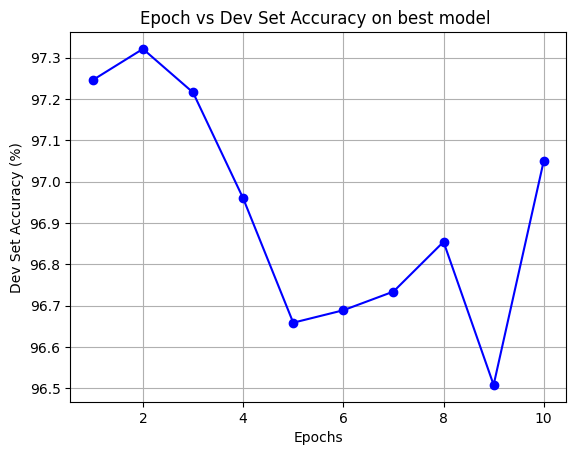

In [26]:
import matplotlib.pyplot as plt

epochs = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
dev_set_accuracy = [97.24563515954245, 97.3208910295003, 97.2155328115593, 96.95966285370258, 96.65863937387115, 96.68874172185431, 96.73389524382901, 96.8543046357616, 96.50812763395545, 97.04996989765202]

plt.plot(epochs, dev_set_accuracy, marker='o', linestyle='-', color='b')
plt.title('Epoch vs Dev Set Accuracy on best model ')
plt.xlabel('Epochs')
plt.ylabel('Dev Set Accuracy (%)')
plt.grid(True)
plt.show()


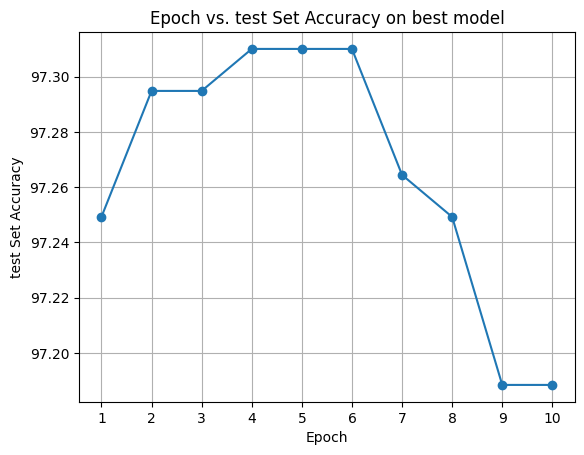

In [21]:
import matplotlib.pyplot as plt

epochs = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
test_set_accuracy = [97.24924012158056, 97.29483282674772, 97.29483282674772, 97.31003039513678, 97.31003039513678, 97.31003039513678, 97.26443768996961, 97.24924012158056, 97.18844984802432, 97.18844984802432]

plt.plot(epochs, test_set_accuracy, marker='o', linestyle='-')
plt.title('Epoch vs. test Set Accuracy on best model')
plt.xlabel('Epoch')
plt.ylabel('test Set Accuracy')
plt.xticks(epochs)
plt.grid(True)
plt.show()
